In [2]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


In [3]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")


Dataset ready: dataset/fruit360


In [4]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]


In [5]:
SIZE = 32
VARIETY = False

transform = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

train_full = Fruit360FolderDataset(TRAIN_DIR, transform=transform, variety=VARIETY)
test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform, variety=VARIETY)

train_size = int(0.7 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

print(f"Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print(f"Classes: {len(train_full.label_to_idx)}")


Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train 91240, Val 39104, Test 43442
Classes: 79


In [6]:
BATCH_SIZE = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_loader)} train batches, {len(val_loader)} val batches, {len(test_loader)} test batches")


913 train batches, 392 val batches, 435 test batches


In [7]:
def extract_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_numpy(train_loader)
X_val, y_val = extract_numpy(val_loader)
X_test, y_test = extract_numpy(test_loader)

print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")


X_train (91240, 3, 32, 32), y_train (91240,)
X_val (39104, 3, 32, 32), y_val (39104,)
X_test (43442, 3, 32, 32), y_test (43442,)


In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened shape: {X_train_flat.shape}")

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_flat)
X_val_sc = scaler.transform(X_val_flat)
X_test_sc = scaler.transform(X_test_flat)

print(f"Features per sample: {X_train_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print("Standardization done")


Flattened shape: (91240, 3072)
Features per sample: 3072
Number of classes: 79
Standardization done


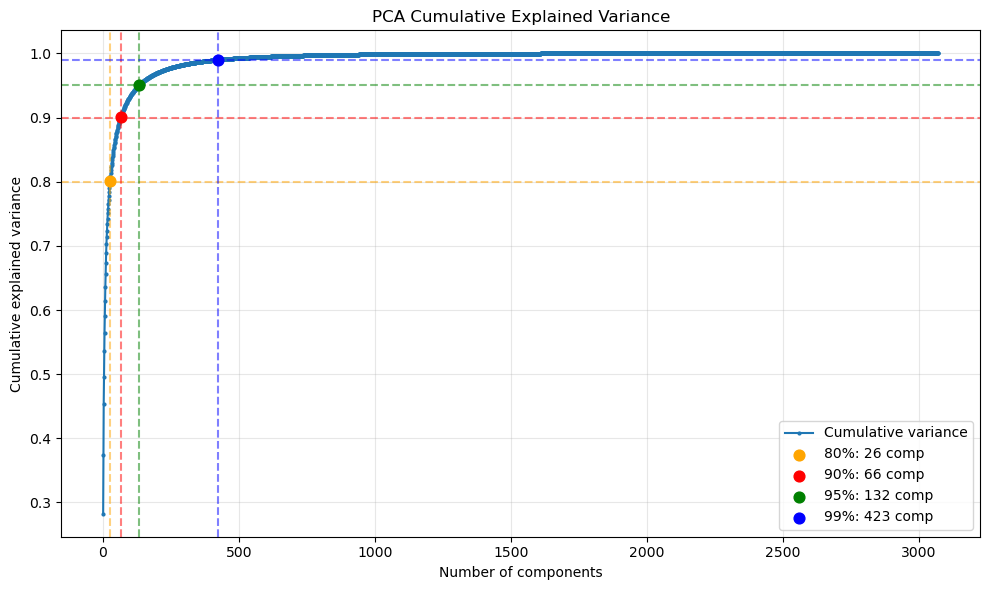

Components needed for each variance target:
  80% variance: 26 components
  90% variance: 66 components
  95% variance: 132 components
  99% variance: 423 components


In [9]:
pca_full = PCA(n_components=min(X_train_sc.shape), random_state=RANDOM_STATE)
pca_full.fit(X_train_sc)

explained = pca_full.explained_variance_ratio_
cumsum = np.cumsum(explained)

targets = [0.80, 0.90, 0.95, 0.99]
components_for_target = {}

for t in targets:
    k = np.argmax(cumsum >= t) + 1
    components_for_target[t] = k

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', markersize=2, label='Cumulative variance')

colors = ['orange', 'red', 'green', 'blue']
for (t, k), col in zip(components_for_target.items(), colors):
    plt.axhline(t, color=col, linestyle='--', alpha=0.5)
    plt.axvline(k, color=col, linestyle='--', alpha=0.5)
    plt.scatter(k, cumsum[k-1], color=col, s=60, zorder=5, 
                label=f'{int(t*100)}%: {k} comp')

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Components needed for each variance target:")
for t, k in components_for_target.items():
    print(f"  {int(t*100)}% variance: {k} components")


In [10]:
n_components_candidates = [
    components_for_target[0.90],
    components_for_target[0.95],
    components_for_target[0.99],
]

C_values = [10, 100]
gamma_values = [0.01, 0.001]

X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_sc, y_train,
    train_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train,
)

print(f"Using subset of size {len(X_train_sub)} from {len(X_train_sc)} for tuning")

results = []

for n_comp in n_components_candidates:
    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_sub_pca = pca_temp.fit_transform(X_train_sub)
    
    for C in C_values:
        for gamma in gamma_values:
            svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)
            scores = cross_val_score(
                svm, X_sub_pca, y_train_sub,
                cv=3, scoring='accuracy', n_jobs=-1,
            )
            mean_score = scores.mean()
            results.append({
                'n_components': n_comp,
                'C': C,
                'gamma': gamma,
                'cv_accuracy': mean_score,
            })
            print(f"n_comp={n_comp:4d}, C={C:3d}, gamma={gamma:.2f} -> CV acc {mean_score:.4f}")

results_df = pd.DataFrame(results).sort_values('cv_accuracy', ascending=False)
best_config = results_df.iloc[0]

print("\nTop configurations:")
print(results_df.head(10))

print("\nBEST CONFIGURATION")
print(f"n_components: {int(best_config['n_components'])}")
print(f"C: {best_config['C']}")
print(f"gamma: {best_config['gamma']}")
print(f"CV accuracy: {best_config['cv_accuracy']:.4f}")


Using subset of size 18248 from 91240 for tuning
n_comp=  66, C= 10, gamma=0.01 -> CV acc 0.7938
n_comp=  66, C= 10, gamma=0.00 -> CV acc 0.9721
n_comp=  66, C=100, gamma=0.01 -> CV acc 0.7938
n_comp=  66, C=100, gamma=0.00 -> CV acc 0.9721
n_comp= 132, C= 10, gamma=0.01 -> CV acc 0.7457
n_comp= 132, C= 10, gamma=0.00 -> CV acc 0.9685
n_comp= 132, C=100, gamma=0.01 -> CV acc 0.7457
n_comp= 132, C=100, gamma=0.00 -> CV acc 0.9685
n_comp= 423, C= 10, gamma=0.01 -> CV acc 0.6735
n_comp= 423, C= 10, gamma=0.00 -> CV acc 0.9625
n_comp= 423, C=100, gamma=0.01 -> CV acc 0.6735
n_comp= 423, C=100, gamma=0.00 -> CV acc 0.9625

Top configurations:
    n_components    C  gamma  cv_accuracy
1             66   10  0.001     0.972107
3             66  100  0.001     0.972107
5            132   10  0.001     0.968545
7            132  100  0.001     0.968545
9            423   10  0.001     0.962517
11           423  100  0.001     0.962517
0             66   10  0.010     0.793840
2             66  

In [11]:
best_n_comp = int(best_config['n_components'])
best_C = best_config['C']
best_gamma = best_config['gamma']

pca_final = PCA(n_components=best_n_comp, random_state=RANDOM_STATE)

X_train_val_sc = np.concatenate([X_train_sc, X_val_sc], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

X_train_val_pca = pca_final.fit_transform(X_train_val_sc)
X_test_pca = pca_final.transform(X_test_sc)

print("Train+Val PCA shape:", X_train_val_pca.shape)
print("Test PCA shape:", X_test_pca.shape)

svm_final = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=RANDOM_STATE)
svm_final.fit(X_train_val_pca, y_train_val)

y_test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nFinal test accuracy: {test_acc:.4f}")


Train+Val PCA shape: (130344, 66)
Test PCA shape: (43442, 66)

Final test accuracy: 0.9742


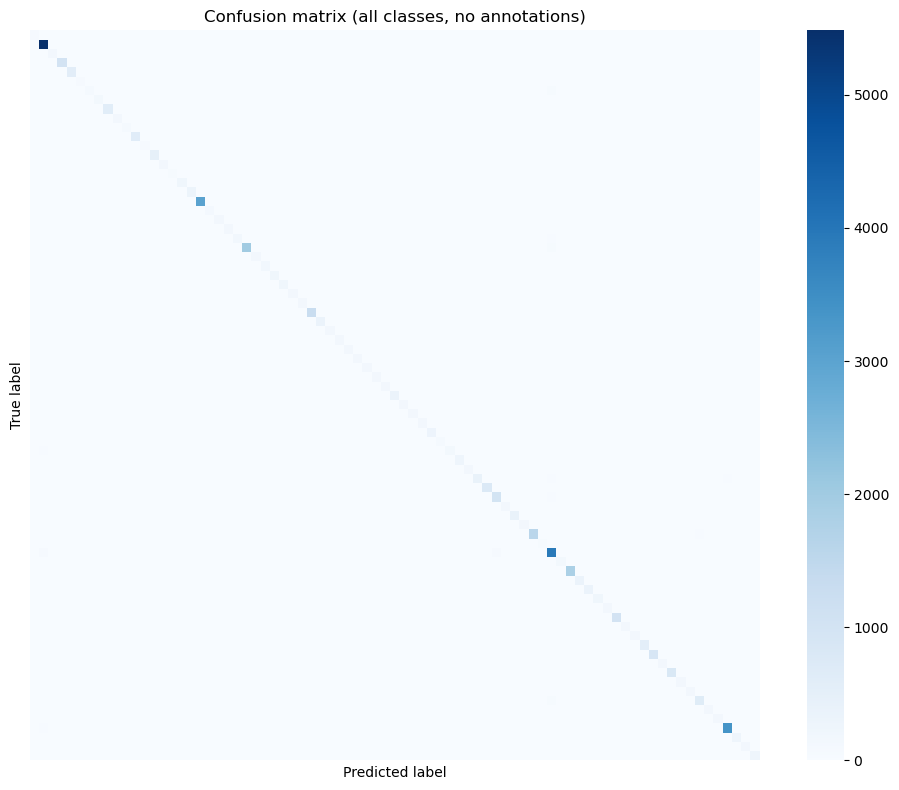

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    cbar=True,
    square=True,
    xticklabels=False,
    yticklabels=False
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (all classes, no annotations)")
plt.tight_layout()
plt.show()


In [13]:
target_names = [train_full.idx_to_label[i] for i in range(len(train_full.label_to_idx))]

print("\nClassification Report (per class):")
print(classification_report(
    y_test, y_test_pred,
    target_names=target_names,
    zero_division=0
))


Classification Report (per class):
              precision    recall  f1-score   support

     Almonds       1.00      1.00      1.00        77
       Apple       0.96      1.00      0.98      5506
     Apricot       0.98      1.00      0.99       164
     Avocado       0.98      1.00      0.99      1017
      Banana       0.99      0.92      0.95       645
       Beans       1.00      1.00      1.00        77
    Beetroot       0.85      0.65      0.73       150
  BlackBerry       1.00      1.00      1.00       145
 Blackberrie       0.98      1.00      0.99       600
   Blueberry       1.00      0.98      0.99       154
     Cabbage       0.99      1.00      0.99        96
      Cactus       0.98      1.00      0.99       634
        Caju       1.00      1.00      1.00        75
  Cantaloupe       1.00      1.00      1.00       484
   Carambula       1.00      0.99      0.99       166
      Carrot       1.00      1.00      1.00        50
 Cauliflower       1.00      0.95      0.98  